In [78]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import torch
import librosa.display as lrdisplay
import librosa.feature as lrfeature

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics as skmetrics

from vxs import *
from vxs.utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
avp_set_fixed = AVPTrackSet('../data/AVP_Dataset', subset='Fixed')
avp_segments_fixed = SegmentSet(avp_set_fixed)

In [3]:
len(avp_segments_fixed)

4897

In [4]:
segm, cl = avp_segments_fixed[20]

hho


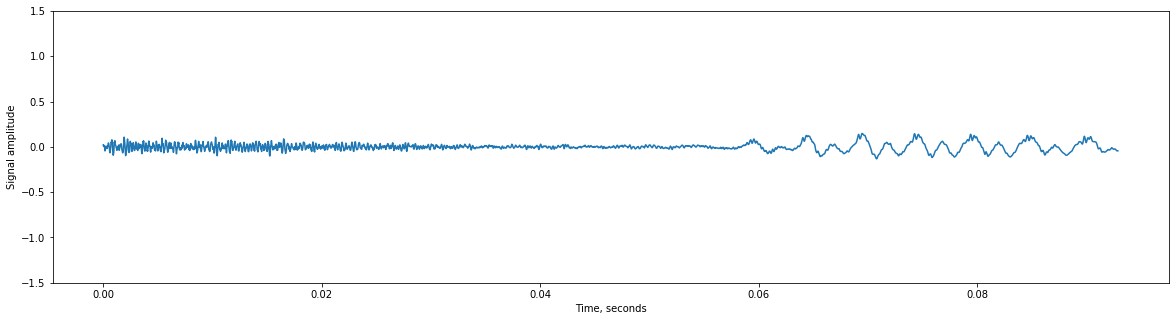

In [5]:
print(cl)
plot_track(segm)

In [6]:
issubclass(type(segm), Track)

True

In [7]:
play_audio(segm)

In [8]:
def unzip_dataset(dataset):
    X = []
    y = []
    for features, label in dataset:
        X.append(features)
        y.append(label)
    return X, y

In [9]:
X, y = unzip_dataset(avp_segments_fixed)

In [107]:
len(X)

4897

In [13]:
avp_set_personal = AVPTrackSet('../data/AVP_Dataset', subset='Personal')
avp_segments_personal = SegmentSet(avp_set_personal)

In [14]:
len(avp_segments_personal)

4306

In [15]:
X_test, y_test = unzip_dataset(avp_segments_personal)

In [42]:
model_mfcc = make_knn_classic('mfcc')
model_mfcc.fit(X, y)

Pipeline(steps=[('features', ClassicFeatureTransformer(feature_type='mfcc')),
                ('normalizer', Normalizer()), ('knn', KNeighborsClassifier())])

In [26]:
for k in [3, 5, 7, 10, 15]:
    model = model_mfcc.set_params(knn__n_neighbors=k)
    y_pred = model.predict(X_test)
    acc = skmetrics.accuracy_score(y_test, y_pred)
    print(f'{k} neighbors: {acc}')

3 neighbors: 0.5724570366929865
5 neighbors: 0.5692057594054807
7 neighbors: 0.5717603344170924
10 neighbors: 0.5745471435206688
15 neighbors: 0.5757083139804924


In [27]:
model_mfcc.set_params(knn__weights='distance')
for k in [3, 5, 7, 10, 15]:
    model = model_mfcc.set_params(knn__n_neighbors=k)
    y_pred = model.predict(X_test)
    acc = skmetrics.accuracy_score(y_test, y_pred)
    print(f'{k} neighbors: {acc}')

3 neighbors: 0.571295866233163
5 neighbors: 0.5687412912215514
7 neighbors: 0.5715281003251277
10 neighbors: 0.5717603344170924
15 neighbors: 0.5768694844403158


In [43]:
y_pred = model_mfcc.predict(X_test)

In [44]:
skmetrics.confusion_matrix(y_test, y_pred)

array([[ 655,  207,   67,  106],
       [ 383,  374,   34,  107],
       [ 124,   37, 1002,  110],
       [ 247,  352,   81,  420]])

In [45]:
skmetrics.accuracy_score(y_test, y_pred)

0.5692057594054807

### Ramires features

In [46]:
model_ramires = make_knn_classic('ramires')
model_ramires.fit(X, y)

Pipeline(steps=[('features', ClassicFeatureTransformer(feature_type='ramires')),
                ('normalizer', Normalizer()), ('knn', KNeighborsClassifier())])

In [47]:
y_pred2 = model_ramires.predict(X_test)

In [48]:
skmetrics.confusion_matrix(y_test, y_pred2)

array([[534, 243,  99, 159],
       [402, 343,  66,  87],
       [240,  45, 726, 262],
       [403, 336,  52, 309]])

In [49]:
skmetrics.accuracy_score(y_test, y_pred2)

0.4440315838365072

### Autoencoder features

In [10]:
model = ConvAE(padding_mode='zeros')
model.load_state_dict(torch.load('../logs/conv_ae_fixed_1/checkpoints/train.19.pth')['model_state_dict'])
encoder = model.encoder
encoder.eval()
model_cae = make_knn_cae(encoder)

In [11]:
model_cae.fit(X, y)

Pipeline(steps=[('cae_features',
                 CAEFeatureTransform(encoder=Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(8, 16, kernel_size=(9, 9), stride=(2, 2), padding=(4, 4))
  (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, trac...
  (6): Conv2d(16, 24, kernel_size=(9, 9), stride=(2, 2), padding=(4, 4))
  (7): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): Conv2d(24, 32, kernel_size=(9, 9), stride=(2, 2), padding=(4, 4))
  (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
))),
                ('knn', KNeighborsClassifier())])

In [16]:
y_pred3 = model_cae.predict(X_test)

In [17]:
skmetrics.confusion_matrix(y_test, y_pred3)

array([[ 697,  159,   81,   98],
       [ 366,  397,   48,   87],
       [ 130,   25, 1004,  114],
       [ 278,  328,  121,  373]])

In [18]:
skmetrics.accuracy_score(y_test, y_pred3)

0.5738504412447747

In [19]:
model_wide = ConvAE(outer_kernel_size=(3,5), strides=[(2,2),(4,2),(4,2),(4,4)], padding_mode='zeros')
model_wide.load_state_dict(torch.load('../logs/conv_ae_fixed_wide_2/checkpoints/best.pth')['model_state_dict'])
model_wide.eval()
model_cae_wide = make_knn_cae(model_wide.encoder)

In [20]:
model_cae_wide.fit(X, y)

Pipeline(steps=[('cae_features',
                 CAEFeatureTransform(encoder=Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 5), stride=(2, 2), padding=(1, 2))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(8, 16, kernel_size=(9, 9), stride=(4, 2), padding=(4, 4))
  (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, trac...
  (6): Conv2d(16, 24, kernel_size=(9, 9), stride=(4, 2), padding=(4, 4))
  (7): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): Conv2d(24, 32, kernel_size=(9, 9), stride=(4, 4), padding=(4, 4))
  (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
))),
                ('knn', KNeighborsClassifier())])

In [21]:
y_pred4 = model_cae_wide.predict(X_test)

In [22]:
skmetrics.confusion_matrix(y_test, y_pred4)

array([[673, 186,  68, 108],
       [348, 412,  50,  88],
       [138,  17, 956, 162],
       [285, 295,  85, 435]])

In [23]:
skmetrics.accuracy_score(y_test, y_pred4)

0.5750116117045982

In [39]:
ftfm = model_cae_wide.named_steps['cae_features']
ftfm.transform(X[:5])[0].shape

(32,)

In [40]:
ftfm_big = model_cae.named_steps['cae_features']
ftfm_big.transform(X[:5])[0].shape

(256,)

### Segmentation + classification

In [25]:
track_10, anno_10 = avp_set_personal.get('P10_Improvisation_Personal')

In [26]:
onsets_pred = detect_onsets(track_10, method='complex')

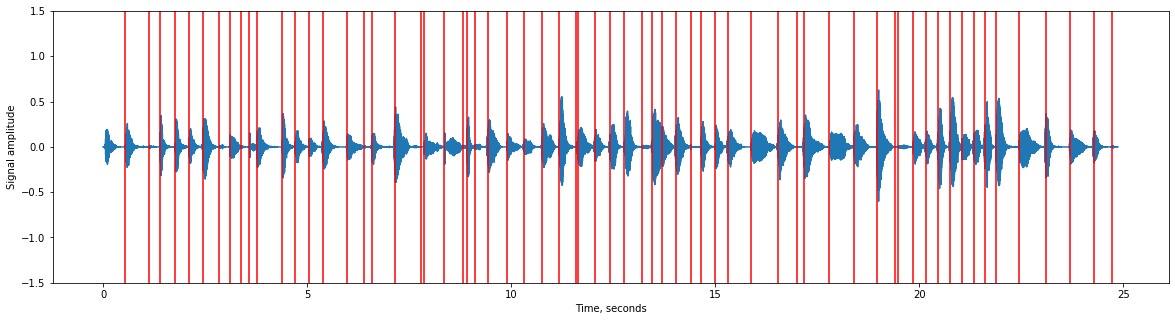

In [27]:
plot_track(track_10, onsets_pred)

In [28]:
def segment_track(track, onsets, segm_frames=4096):
    segments = []
    for idx, onset in onsets.iterrows():
        time = onset['time']
        segm = track.segment_frames(int(track.rate * time), segm_frames)
        segments.append((time, segm))
    return segments

In [29]:
segments = segment_track(track_10, onsets_pred)

In [30]:
def predict_series(model, segments):
    prediction = pd.DataFrame(columns=['time', 'class'])
    for i, (time, segm) in enumerate(segments):
        [cl] = model.predict([segm])
        prediction.loc[i] = [time, cl]
    return prediction

In [33]:
pred1 = predict_series(model_cae_wide, segments)

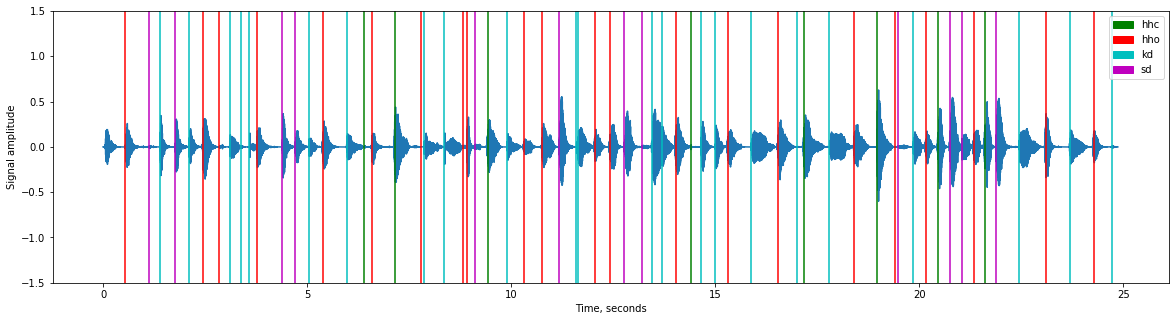

In [34]:
plot_track(track_10, pred1, color_events=True)

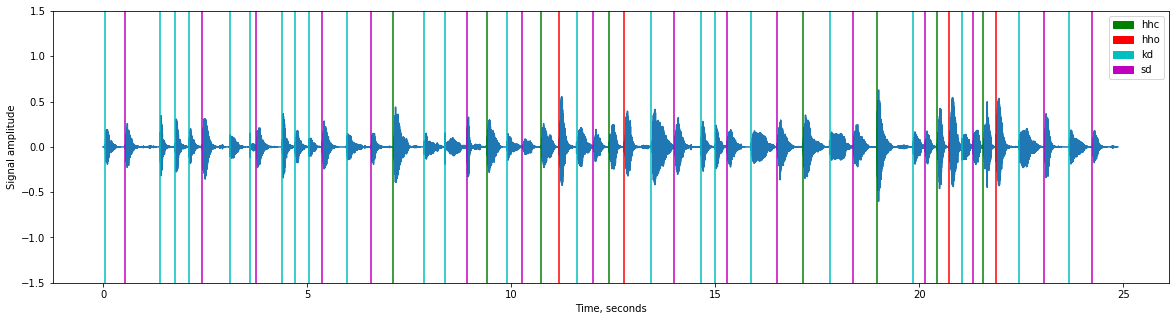

In [35]:
plot_track(track_10, anno_10, color_events=True)

In [36]:
classes_F1_score(pred1, anno_10, ms_threshold=50)

,hhc,hho,kd,sd,sil
hhc,6,2,0,0,0
hho,0,0,0,4,0
kd,0,0,18,4,1
sd,0,16,0,0,0
sil,2,4,5,4,0


In [66]:
def segment_classify(track, model):
    onsets = detect_onsets(track, method='complex')
    segments = segment_track(track, onsets)
    return predict_series(model, segments)

def segment_classify_all(trackset, model, verbose=False):
    total_cf = None
    for i, (track, anno) in enumerate(avp_set_personal.annotated_tracks()):
        pred = segment_classify(track, model)
        cf = classes_F1_score(pred, anno)
        
        if total_cf is None:
            total_cf = cf
        else:
            total_cf = total_cf.add(cf, fill_value=0)
            
        if verbose:
            print(f'track {i} done')
            
    return total_cf

In [69]:
%%time
mfcc_cf = segment_classify_all(avp_set_personal, model_mfcc, verbose=True)

track 0 done
track 1 done
track 2 done
track 3 done
track 4 done
track 5 done
track 6 done
track 7 done
track 8 done
track 9 done
track 10 done
track 11 done
track 12 done
track 13 done
track 14 done
track 15 done
track 16 done
track 17 done
track 18 done
track 19 done
track 20 done
track 21 done
track 22 done
track 23 done
track 24 done
track 25 done
track 26 done
track 27 done
track 28 done
track 29 done
track 30 done
track 31 done
track 32 done
track 33 done
track 34 done
track 35 done
track 36 done
track 37 done
track 38 done
track 39 done
track 40 done
track 41 done
track 42 done
track 43 done
track 44 done
track 45 done
track 46 done
track 47 done
track 48 done
track 49 done
track 50 done
track 51 done
track 52 done
track 53 done
track 54 done
track 55 done
track 56 done
track 57 done
track 58 done
track 59 done
track 60 done
track 61 done
track 62 done
track 63 done
track 64 done
track 65 done
track 66 done
track 67 done
track 68 done
track 69 done
track 70 done
track 71 done
tr

In [70]:
mfcc_cf = mfcc_cf.drop('pm', 0).drop('pm', 1)
mfcc_cf

,hhc,hho,kd,sd,sil
hhc,639.0,199.0,63.0,103.0,32.0
hho,363.0,339.0,33.0,124.0,44.0
kd,128.0,19.0,929.0,110.0,88.0
sd,239.0,310.0,84.0,444.0,24.0
sil,99.0,80.0,205.0,78.0,0.0


In [71]:
%%time
ramires_cf = segment_classify_all(avp_set_personal, model_ramires, verbose=True)

track 0 done
track 1 done
track 2 done
track 3 done
track 4 done
track 5 done
track 6 done
track 7 done
track 8 done
track 9 done
track 10 done
track 11 done
track 12 done
track 13 done
track 14 done
track 15 done
track 16 done
track 17 done
track 18 done
track 19 done
track 20 done
track 21 done
track 22 done
track 23 done
track 24 done
track 25 done
track 26 done
track 27 done
track 28 done
track 29 done
track 30 done
track 31 done
track 32 done
track 33 done
track 34 done
track 35 done
track 36 done
track 37 done
track 38 done
track 39 done
track 40 done
track 41 done
track 42 done
track 43 done
track 44 done
track 45 done
track 46 done
track 47 done
track 48 done
track 49 done
track 50 done
track 51 done
track 52 done
track 53 done
track 54 done
track 55 done
track 56 done
track 57 done
track 58 done
track 59 done
track 60 done
track 61 done
track 62 done
track 63 done
track 64 done
track 65 done
track 66 done
track 67 done
track 68 done
track 69 done
track 70 done
track 71 done
tr

In [87]:
ramires_cf = ramires_cf.drop('pm', 0).drop('pm', 1)
ramires_cf

,hhc,hho,kd,sd,sil
hhc,521.0,245.0,96.0,142.0,32.0
hho,392.0,326.0,57.0,84.0,44.0
kd,222.0,37.0,674.0,253.0,88.0
sd,382.0,323.0,53.0,319.0,24.0
sil,158.0,76.0,128.0,100.0,0.0


In [73]:
%%time
cf_cae_sq = segment_classify_all(avp_set_personal, model_cae, verbose=True)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 14.5 µs
track 0 done
track 1 done
track 2 done
track 3 done
track 4 done
track 5 done
track 6 done
track 7 done
track 8 done
track 9 done
track 10 done
track 11 done
track 12 done
track 13 done
track 14 done
track 15 done
track 16 done
track 17 done
track 18 done
track 19 done
track 20 done
track 21 done
track 22 done
track 23 done
track 24 done
track 25 done
track 26 done
track 27 done
track 28 done
track 29 done
track 30 done
track 31 done
track 32 done
track 33 done
track 34 done
track 35 done
track 36 done
track 37 done
track 38 done
track 39 done
track 40 done
track 41 done
track 42 done
track 43 done
track 44 done
track 45 done
track 46 done
track 47 done
track 48 done
track 49 done
track 50 done
track 51 done
track 52 done
track 53 done
track 54 done
track 55 done
track 56 done
track 57 done
track 58 done
track 59 done
track 60 done
track 61 done
track 62 done
track 63 done
track 64 done
track 65 done
track 66 done
track 67

In [100]:
#cf_cae_sq = cf_cae_sq.drop('pm', 0).drop('pm', 1)
cf_cae_sq

,hhc,hho,kd,sd,sil
hhc,701.0,121.0,74.0,108.0,32.0
hho,426.0,306.0,42.0,85.0,44.0
kd,128.0,12.0,924.0,122.0,88.0
sd,288.0,264.0,101.0,424.0,24.0
sil,91.0,78.0,213.0,80.0,0.0


In [75]:
%%time
cf_cae_wide = segment_classify_all(avp_set_personal, model_cae_wide, verbose=True)

track 0 done
track 1 done
track 2 done
track 3 done
track 4 done
track 5 done
track 6 done
track 7 done
track 8 done
track 9 done
track 10 done
track 11 done
track 12 done
track 13 done
track 14 done
track 15 done
track 16 done
track 17 done
track 18 done
track 19 done
track 20 done
track 21 done
track 22 done
track 23 done
track 24 done
track 25 done
track 26 done
track 27 done
track 28 done
track 29 done
track 30 done
track 31 done
track 32 done
track 33 done
track 34 done
track 35 done
track 36 done
track 37 done
track 38 done
track 39 done
track 40 done
track 41 done
track 42 done
track 43 done
track 44 done
track 45 done
track 46 done
track 47 done
track 48 done
track 49 done
track 50 done
track 51 done
track 52 done
track 53 done
track 54 done
track 55 done
track 56 done
track 57 done
track 58 done
track 59 done
track 60 done
track 61 done
track 62 done
track 63 done
track 64 done
track 65 done
track 66 done
track 67 done
track 68 done
track 69 done
track 70 done
track 71 done
tr

In [89]:
cf_cae_wide = cf_cae_wide.drop('pm', 0).drop('pm', 1)
cf_cae_wide

,hhc,hho,kd,sd,sil
hhc,708.0,118.0,63.0,115.0,32.0
hho,423.0,291.0,44.0,101.0,44.0
kd,137.0,13.0,871.0,165.0,88.0
sd,286.0,235.0,70.0,486.0,24.0
sil,119.0,72.0,167.0,104.0,0.0


In [92]:
def cf_to_prec_rec_F1(cf):
    classes = list(cf.columns)
    classes.remove('sil')
    res = pd.DataFrame(columns=['prec', 'rec', 'F1'], index=classes)
    for cl in classes:
        tp = cf.loc[cl, cl]
        fp = cf.loc[:, cl].sum() - tp
        fn = cf.loc[cl, :].sum() - tp
        prec = tp / (tp + fp)
        rec = tp / (tp + fn)
        if prec == 0 or rec == 0:
            f1 = 0
        else:
            f1 = 2 * prec * rec / (prec + rec)
        res.loc[cl] = [prec, rec, f1]
    return res

In [93]:
mfcc_scores = cf_to_prec_rec_F1(mfcc_cf)
mfcc_scores

,prec,rec,F1
hhc,0.435286,0.616795,0.510383
hho,0.357973,0.375415,0.366486
kd,0.707002,0.729199,0.717929
sd,0.51688,0.40327,0.453061


In [94]:
mfcc_scores.mean()

prec    0.504285
rec     0.531170
F1      0.511965
dtype: float64

In [96]:
ramires_scores = cf_to_prec_rec_F1(ramires_cf)
ramires_scores

,prec,rec,F1
hhc,0.311045,0.502896,0.38436
hho,0.323734,0.361019,0.341361
kd,0.668651,0.529042,0.59071
sd,0.355234,0.289737,0.31916


In [97]:
ramires_scores.mean()

prec    0.414666
rec     0.420673
F1      0.408898
dtype: float64

In [102]:
cae_sq_scores = cf_to_prec_rec_F1(cf_cae_sq)
cae_sq_scores

,prec,rec,F1
hhc,0.429009,0.676641,0.525094
hho,0.391805,0.33887,0.36342
kd,0.682422,0.725275,0.703196
sd,0.517705,0.385104,0.441667


In [103]:
cae_sq_scores.mean()

prec    0.505235
rec     0.531473
F1      0.508344
dtype: float64

In [104]:
cae_wide_scores = cf_to_prec_rec_F1(cf_cae_wide)
cae_wide_scores

,prec,rec,F1
hhc,0.423192,0.683398,0.522702
hho,0.399177,0.322259,0.356618
kd,0.716872,0.683673,0.699879
sd,0.500515,0.441417,0.469112


In [106]:
cae_wide_scores.mean()

prec    0.509939
rec     0.532687
F1      0.512078
dtype: float64